In [15]:
# AMES Dataset Regression Analysis
# A comprehensive solution for regression modeling

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


In [16]:
# ----------------------------------------------------------------
# 1. Data Understanding
# ----------------------------------------------------------------

# 1a. Identify irrelevant columns based on business understanding
print("\n\n1a. Identifying potentially irrelevant variables based on business understanding:")
# For better visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [8,6]

# Mount Google Drive to access local files
# from google.colab import drive
# drive.mount('/content/drive')import pandas as pd
import os

# Define file paths (modify these to match your local file locations)
train_path = 'ames_train.csv'  # Path to your training data
test_path = 'ames_test.csv'    # Path to your test data

# Check if files exist before loading
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Training file not found at: {train_path}")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Test file not found at: {test_path}")

# Load the datasets
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Verify successful loading
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Identify potentially irrelevant columns (same as before)
irrelevant_cols = [
    'Id',  # Just an identifier
    'PID',  # Parcel identification number
    'MSSubClass',  # Building class (better alternatives exist)
    'MoSold', 'YrSold',  # Sale timing shouldn't affect price
    'SaleType', 'SaleCondition',  # Sale conditions often not relevant
    'GarageYrBlt',  # Redundant with YearBuilt
    'OverallCond',  # OverallQual is better
    'BsmtFinSF2', 'LowQualFinSF',  # Rare or unimportant features
    '3SsnPorch', 'ScreenPorch', 'PoolArea'  # Rare amenities
]

print(f"\nColumns proposed for elimination: {irrelevant_cols}")

# Show first few rows of training data
print("\nTraining data preview:")
print(train_data.head())




1a. Identifying potentially irrelevant variables based on business understanding:
Training data shape: (1460, 81)
Test data shape: (1459, 80)

Columns proposed for elimination: ['Id', 'PID', 'MSSubClass', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'GarageYrBlt', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', '3SsnPorch', 'ScreenPorch', 'PoolArea']

Training data preview:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl



1b. Statistical evidence to support elimination:

Numeric columns analysis:
Correlation with SalePrice for proposed numeric columns to eliminate:
GarageYrBlt     0.486362
ScreenPorch     0.111447
PoolArea        0.092404
MSSubClass      0.084284
OverallCond     0.077856
MoSold          0.046432
3SsnPorch       0.044584
YrSold          0.028923
LowQualFinSF    0.025606
Id              0.021917
BsmtFinSF2      0.011378
Name: SalePrice, dtype: float64


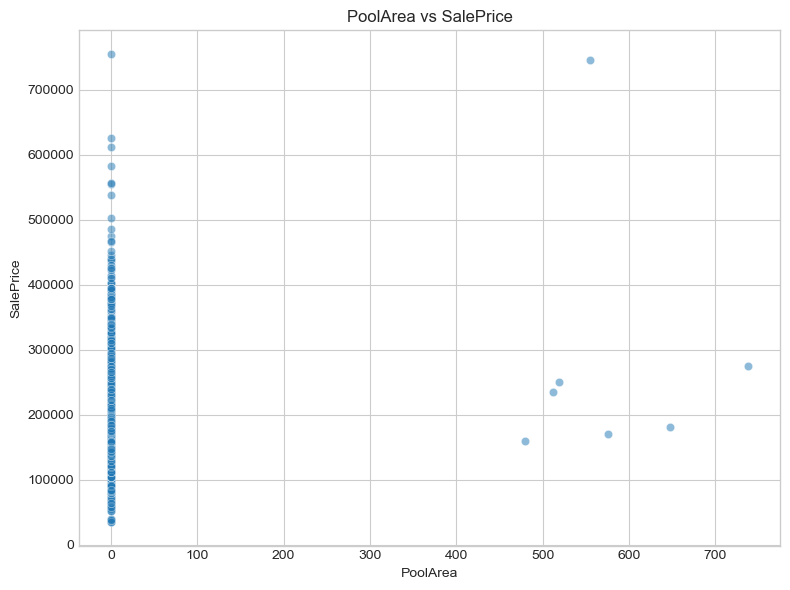

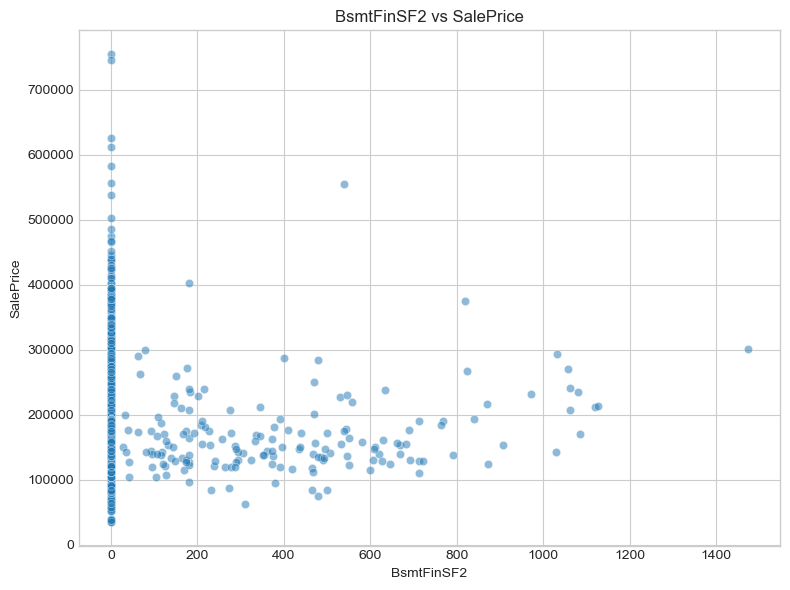

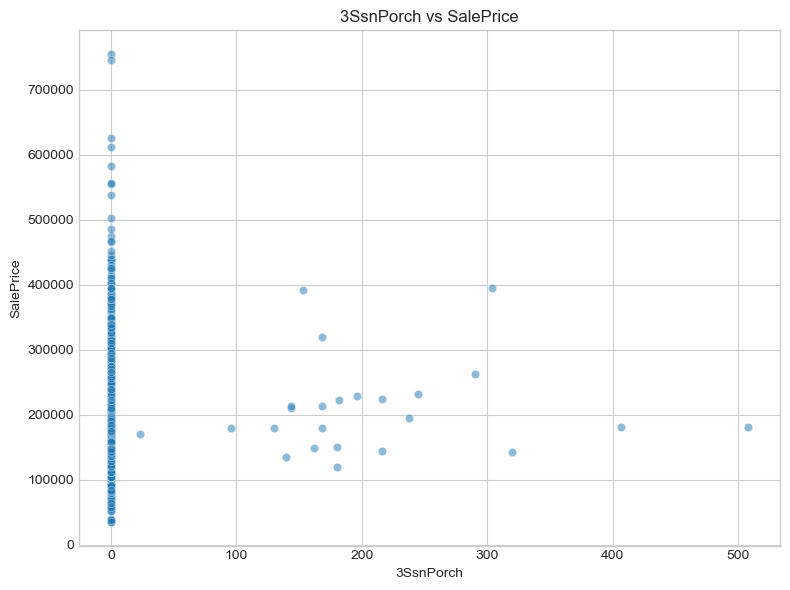


Categorical columns analysis:
ANOVA for SaleType: F-value=110.90, p-value=0.0000


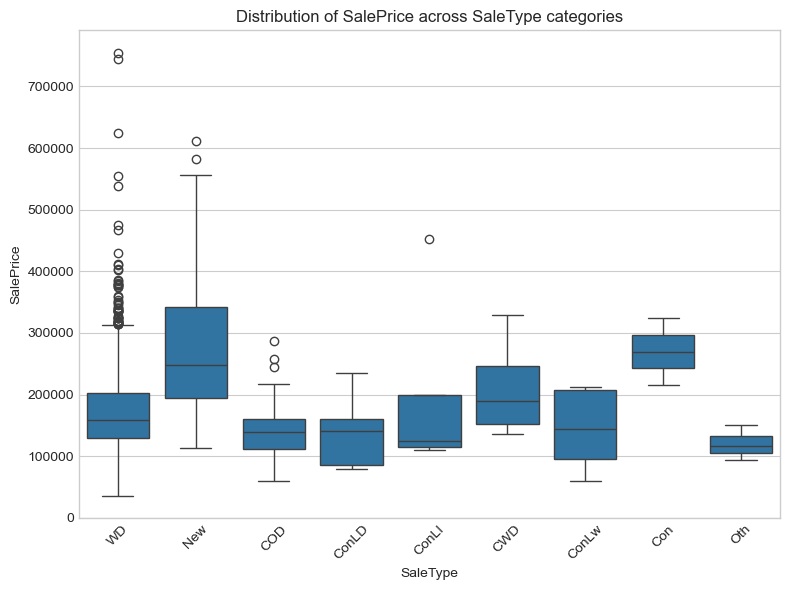

ANOVA for SaleCondition: F-value=55.79, p-value=0.0000


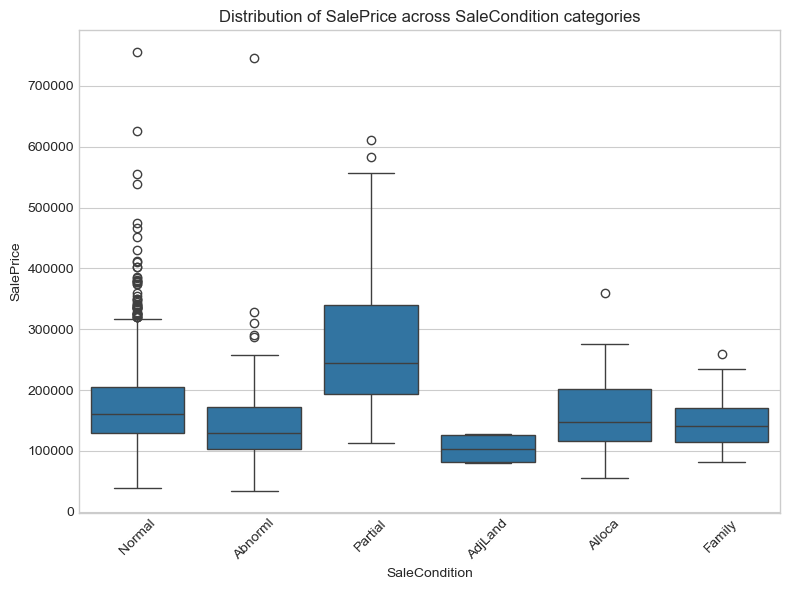


Checking for near-zero variance columns:
Column 'PID' not found in training data


In [17]:
# 1b. Statistical evidence to support elimination
print("\n\n1b. Statistical evidence to support elimination:")

# First, separate numeric and non-numeric columns
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
non_numeric_cols = train_data.select_dtypes(include=['object']).columns

# For numeric columns: correlation analysis
print("\nNumeric columns analysis:")
if 'SalePrice' in numeric_cols:
    numeric_corr = train_data[numeric_cols].corr()['SalePrice'].abs().sort_values(ascending=False)
    # Filter to only show correlations for columns we're considering eliminating
    irrelevant_numeric = [col for col in irrelevant_cols if col in numeric_cols]
    print("Correlation with SalePrice for proposed numeric columns to eliminate:")
    print(numeric_corr[numeric_corr.index.isin(irrelevant_numeric)])
    
    # Visual inspection for numeric columns
    for col in ['PoolArea', 'BsmtFinSF2', '3SsnPorch']:  # Example numeric columns
        if col in train_data.columns:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=col, y='SalePrice', data=train_data, alpha=0.5)
            plt.title(f"{col} vs SalePrice")
            plt.tight_layout()
            plt.savefig(f"{col}_vs_SalePrice.png")
            plt.show()

# For categorical columns: ANOVA tests
print("\nCategorical columns analysis:")
for col in ['MSSubClass', 'SaleType', 'SaleCondition']:  # Example categorical columns
    if col in non_numeric_cols and col in irrelevant_cols:
        try:
            # Create groups for ANOVA
            groups = [group['SalePrice'].values 
                     for name, group in train_data.groupby(col) 
                     if len(group) > 10]  # Only include groups with sufficient samples
            
            if len(groups) > 1:  # Need at least 2 groups to compare
                f_val, p_val = stats.f_oneway(*groups)
                print(f"ANOVA for {col}: F-value={f_val:.2f}, p-value={p_val:.4f}")
                
                # Visual inspection
                plt.figure(figsize=(8, 6))
                sns.boxplot(x=col, y='SalePrice', data=train_data)
                plt.title(f"Distribution of SalePrice across {col} categories")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(f"{col}_boxplot.png")
                plt.show()
        except Exception as e:
            print(f"Could not process {col}: {str(e)}")

# Additional check for zero-variance columns
print("\nChecking for near-zero variance columns:")
for col in irrelevant_cols:
    try:
        if col in train_data.columns:
            unique_values = train_data[col].nunique()
            if unique_values == 1:
                print(f"{col} has only 1 unique value - good candidate for removal")
            elif unique_values < 5:
                print(f"{col} has only {unique_values} unique values")
            # You might want to see the value counts for low-variance columns
            if unique_values < 5:
                print(f"Value counts for {col}:")
                print(train_data[col].value_counts())
                print("-"*40)
        else:
            print(f"Column '{col}' not found in training data")
    except Exception as e:
        print(f"Error analyzing column '{col}': {str(e)}")

In [18]:
data = train_data.copy()
# 1c. Make a final decision on variables to eliminate
print("\n\n1c. Final decision on variables to eliminate:")
# Drop the irrelevant columns (keeping only those that exist in the dataset)
cols_to_drop = [col for col in irrelevant_cols if col in data.columns]
data_reduced = data.drop(cols_to_drop, axis=1)

print(f"\nOriginal shape: {data.shape}")
print(f"Reduced shape: {data_reduced.shape}")
print(f"Dropped {len(cols_to_drop)} columns")



1c. Final decision on variables to eliminate:

Original shape: (1460, 81)
Reduced shape: (1460, 68)
Dropped 13 columns


In [19]:
# ----------------------------------------------------------------
# 2. Data Scaling and Pre-Processing
# ----------------------------------------------------------------

# 2a. Check for missing values, outliers, etc.
print("\n\n2a. Checking for data quality issues:")

# Missing values analysis
missing_values = data_reduced.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing values:\n", missing_values)

# Treatment for missing values
# For numerical: fill with median or 0 depending on feature
# For categorical: fill with 'None' or mode
for col in data_reduced.select_dtypes(include=['int64', 'float64']).columns:
    if col in missing_values:
        if data_reduced[col].dtype == 'object':
            data_reduced[col].fillna('None', inplace=True)
        else:
            data_reduced[col].fillna(0, inplace=True)

# Outlier detection and treatment (using z-score for numerical features)
numeric_cols = data_reduced.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if col != 'SalePrice':  # Don't treat target variable
        z_scores = np.abs(stats.zscore(data_reduced[col]))
        data_reduced = data_reduced[(z_scores < 3)]  # Remove outliers beyond 3 std dev

# Check for duplicate rows
duplicates = data_reduced.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
data_reduced.drop_duplicates(inplace=True)



2a. Checking for data quality issues:
Missing values:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

Number of duplicate rows: 0


In [20]:
# 2b. Determine which features need scaling and select scaling technique
print("\n\n2b. Determining features for scaling:")

# Identify numeric features that need scaling
numeric_features = data_reduced.select_dtypes(include=['int64', 'float64']).columns
numeric_features = numeric_features.drop('SalePrice')  # Don't scale target

# Features that don't need scaling (already in good range or binary)
no_scale_needed = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 
                   'TotRmsAbvGrd', 'GarageCars', 'FullBath', 'HalfBath']

# Features that need scaling
scale_needed = [col for col in numeric_features if col not in no_scale_needed]

print("\nFeatures that need scaling:", scale_needed)
print("Features that don't need scaling:", no_scale_needed)

# Choose StandardScaler (assumes normal distribution, preserves outliers)
# MinMaxScaler would be better if we had bounded features or wanted to preserve zeros
scaler = StandardScaler()



2b. Determining features for scaling:

Features that need scaling: ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'MiscVal']
Features that don't need scaling: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'TotRmsAbvGrd', 'GarageCars', 'FullBath', 'HalfBath']


In [21]:
# 2c. Special consideration for PoolArea
print("\n\n2c. Analysis of PoolArea for scaling:")

# First check if the column exists (case-insensitive check)
pool_col = None
for col in data_reduced.columns:
    if col.lower() == 'poolarea':
        pool_col = col
        break

if pool_col:
    print(f"\nFound pool column: '{pool_col}'")
    
    # PoolArea is special because it's mostly zeros (few houses have pools)
    print("\nPoolArea value counts before scaling:")
    print(data_reduced[pool_col].value_counts())
    
    # Create binary feature for pool existence
    data_reduced['HasPool'] = (data_reduced[pool_col] > 0).astype(int)
    data_reduced.drop(pool_col, axis=1, inplace=True)
    
    print("\nAfter transformation:")
    print(data_reduced['HasPool'].value_counts())
    print(f"Percentage of homes with pools: {data_reduced['HasPool'].mean()*100:.2f}%")
else:
    print("\nPoolArea column not found in data_reduced. Available columns:")
    print(data_reduced.columns.tolist())



2c. Analysis of PoolArea for scaling:

PoolArea column not found in data_reduced. Available columns:
['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'PoolQC', 'Fence', 'MiscF

In [22]:
# 2d. Categorical variables encoding
print("\n\n2d. Categorical variables encoding strategy:")

# Identify categorical columns
categorical_cols = data_reduced.select_dtypes(include=['object']).columns

# Smart encoding techniques:
# 1. For ordinal categories: manual mapping
ordinal_mapping = {
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
    # Add other ordinal features similarly
}

for col, mapping in ordinal_mapping.items():
    if col in data_reduced.columns:
        data_reduced[col] = data_reduced[col].map(mapping).fillna(0)

# 2. For high-cardinality nominal: top-N encoding
for col in categorical_cols:
    if col not in ordinal_mapping and col in data_reduced.columns:
        top_categories = data_reduced[col].value_counts().nlargest(5).index
        data_reduced[col] = np.where(data_reduced[col].isin(top_categories), 
                                   data_reduced[col], 'Other')

# 3. One-hot encoding for remaining nominal with reduced dimensions
data_reduced = pd.get_dummies(data_reduced, columns=[col for col in categorical_cols 
                              if col not in ordinal_mapping and col in data_reduced.columns],
                             drop_first=True)

print("\nShape after encoding:", data_reduced.shape)



2d. Categorical variables encoding strategy:

Shape after encoding: (1123, 172)


In [23]:

# 3a. Choose metric to optimize for regression
print("\n\n3a. Choosing metrics for regression optimization:")
# For regression, we'll use:
# 1. RMSE (Root Mean Squared Error) - primary metric as it's in same units as target
# 2. R-squared - to explain variance explained
# 3. MAE (Mean Absolute Error) - robust to outliers

print("We'll optimize for RMSE while monitoring R-squared and MAE")



3a. Choosing metrics for regression optimization:
We'll optimize for RMSE while monitoring R-squared and MAE


In [24]:

# 3b. Implement Statsmodel OLS and drop insignificant variables
print("\n\n3b. Implementing Statsmodel OLS and dropping insignificant variables:")

# First ensure all data is numeric
X = data_reduced.select_dtypes(include=['number'])  # Select only numeric columns
X = X.drop('SalePrice', axis=1, errors='ignore')  # Make sure target is removed
y = data_reduced['SalePrice']

# Add constant after ensuring numeric data
X = sm.add_constant(X, has_constant='add')  # Ensure constant is properly added

# Modified function that returns 3 values
def auto_drop_insignificant(X, y, threshold=0.05):
    features_dropped = []
    try:
        while True:
            model = sm.OLS(y, X).fit()
            p_values = model.pvalues
            max_p = p_values.max()
            
            if max_p > threshold:
                insignificant_feature = p_values.idxmax()
                if insignificant_feature == 'const':
                    print("Constant term is insignificant but we'll keep it")
                    break
                print(f"Dropping {insignificant_feature} with p-value {max_p:.4f}")
                X = X.drop(insignificant_feature, axis=1)
                features_dropped.append(insignificant_feature)
            else:
                break
                
        final_model = sm.OLS(y, X).fit()
        return final_model, X, features_dropped
    
    except Exception as e:
        print(f"Error in auto_drop_insignificant: {str(e)}")
        print("Current columns:", X.columns.tolist())
        return None, None, None

# Now unpack all 3 return values
final_model, X_significant, features_dropped = auto_drop_insignificant(X, y)

if final_model is not None:
    print("\nFinal OLS Model Summary:")
    print(final_model.summary())
    print("\nFeatures dropped:", features_dropped)
    print("Remaining features:", X_significant.columns.tolist())
    
    # Now proceed with VIF analysis using X_significant (without 'const')
    significant_features = X_significant.drop('const', axis=1)





3b. Implementing Statsmodel OLS and dropping insignificant variables:
Dropping MiscVal with p-value 0.9876
Dropping EnclosedPorch with p-value 0.6616
Dropping HalfBath with p-value 0.6215
Dropping BsmtFullBath with p-value 0.5732
Dropping GarageCars with p-value 0.3839
Dropping GrLivArea with p-value 0.2665
Dropping FullBath with p-value 0.2115
Dropping BsmtQual with p-value 0.0878
Dropping MasVnrArea with p-value 0.0862

Final OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     483.7
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:45:32   Log-Likelihood:                -12831.
No. Observations:                1123   AIC:                         2.57

In [25]:
# 3c. VIF Analysis
print("\n\n3c. Calculating VIF scores:")

# First check if we have valid features from previous step
if final_model is None:
    print("Error: No valid model from previous step. Cannot calculate VIF.")
    print("Debugging previous step...")
    
    # Recreate X with proper numeric columns
    X = data_reduced.select_dtypes(include=['number']).drop('SalePrice', axis=1, errors='ignore')
    X = sm.add_constant(X, has_constant='add')
    
    print("\nCurrent X matrix info:")
    print("Shape:", X.shape)
    print("Columns:", X.columns.tolist())
    print("Missing values:", X.isna().sum().sum())
    
    # Try a simpler model with fewer features if still failing
    if len(X.columns) > 20:  # If too many features
        top_features = X.corrwith(y).abs().nlargest(10).index
        X = X[top_features]
        print("\nTrying with top 10 correlated features:", top_features.tolist())
    
    # Rerun modeling - now expecting 3 return values
    final_model, X_significant, features_dropped = auto_drop_insignificant(X, y)
    
    if final_model is None:
        print("\nModeling still failing. Possible solutions:")
        print("1. Check for missing values in X:", X.isna().sum().sum())
        print("2. Check for infinite values:", np.isinf(X.select_dtypes(include=np.number)).sum().sum())
        print("3. Try converting all columns to numeric:")
        X = X.apply(pd.to_numeric, errors='coerce').dropna(axis=1)
        print("New X shape:", X.shape)
        # Exit if still failing
        exit()

    # If we succeeded in rebuilding the model, set significant_features
    significant_features = X_significant.drop('const', axis=1)

# Proceed with VIF calculation if we have valid features
try:
    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = significant_features.columns
    vif_data["VIF"] = [variance_inflation_factor(significant_features.values, i) 
                      for i in range(len(significant_features.columns))]
    
    print("\nVIF Scores:")
    print(vif_data.sort_values('VIF', ascending=False))
    
    # Drop high VIF features (threshold > 5)
    high_vif = vif_data[vif_data['VIF'] > 5]['feature'].tolist()
    if high_vif:
        print("\nDropping high VIF features:", high_vif)
        significant_features_low_vif = significant_features.drop(high_vif, axis=1)
        
        # Refit model
        X_low_vif = sm.add_constant(significant_features_low_vif)
        final_model_low_vif = sm.OLS(y, X_low_vif).fit()
        
        print("\nModel after dropping high VIF features:")
        print(final_model_low_vif.summary())
    else:
        print("\nNo high VIF features found (all VIF <= 5)")
        
except Exception as e:
    print("\nError calculating VIF:", str(e))
    print("Problematic features:", significant_features.columns.tolist())
    print("Feature matrix shape:", significant_features.shape)



3c. Calculating VIF scores:

VIF Scores:
         feature           VIF
13  KitchenAbvGr  17617.210592
8    TotalBsmtSF      8.967787
7      BsmtUnfSF      7.999477
6     BsmtFinSF1      7.801300
9       1stFlrSF      5.450637
10      2ndFlrSF      4.201212
14  TotRmsAbvGrd      3.953738
2    OverallQual      3.336588
5      ExterQual      2.516457
3      YearBuilt      2.490028
12  BedroomAbvGr      2.211680
4   YearRemodAdd      2.063882
16    GarageArea      1.865140
15    Fireplaces      1.442232
1        LotArea      1.400646
18   OpenPorchSF      1.248054
0    LotFrontage      1.157945
17    WoodDeckSF      1.145909
11  BsmtHalfBath           NaN

Dropping high VIF features: ['BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'KitchenAbvGr']

Model after dropping high VIF features:
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.822
Model:                            OLS 



3d. Residual analysis:


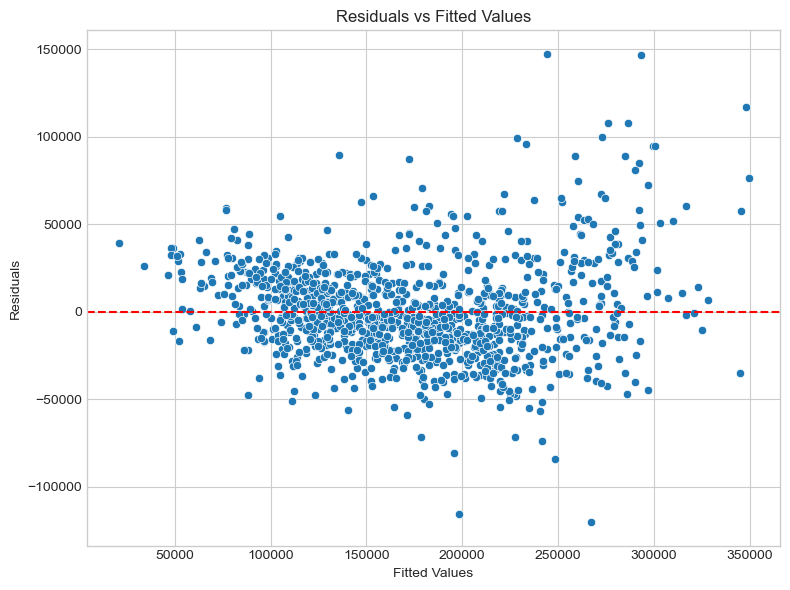

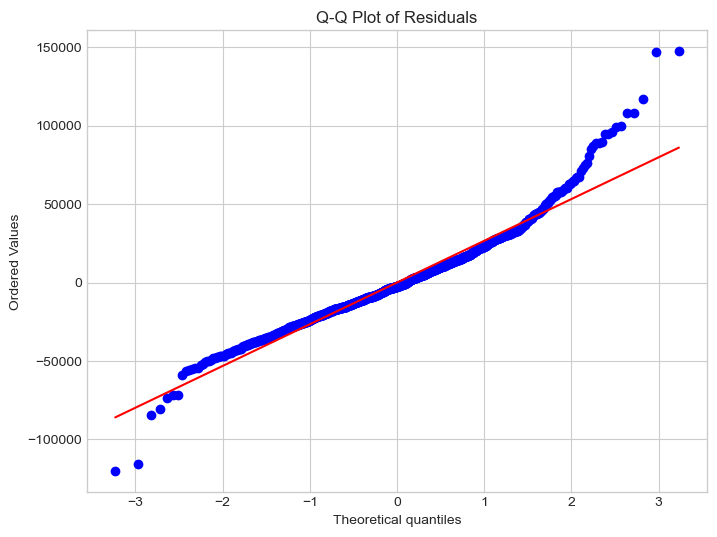


Original model R-squared: 0.8220236241837905
Log-transformed model R-squared: 0.834367116184149


In [26]:
# 3d. Residual analysis
print("\n\n3d. Residual analysis:")

# Get residuals from final model
residuals = final_model_low_vif.resid
fitted_values = final_model_low_vif.fittedvalues

# Residual vs Fitted plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.savefig('residuals_vs_fitted.png', dpi=300, bbox_inches='tight')
plt.tight_layout()  
plt.show()

# Check normality of residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.savefig('qq_plot_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# If residuals show heteroscedasticity or non-normality, try transformations
# Let's try log transformation of target
y_log = np.log1p(y)
model_log = sm.OLS(y_log, X_low_vif).fit()

# Compare R-squared
print("\nOriginal model R-squared:", final_model_low_vif.rsquared)
print("Log-transformed model R-squared:", model_log.rsquared)

In [27]:
# 3e. Gradient-based regressor (continued)
print("\n\n3e. Implementing gradient-based regressor:")

import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    significant_features_low_vif, 
    y, 
    test_size=0.2, 
    random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SGD Regressor with improved parameters
sgd = SGDRegressor(
    max_iter=5000,  # Increased iterations for better convergence
    tol=1e-4,       # Tighter tolerance
    penalty='l2', 
    alpha=0.0001, 
    random_state=42,
    early_stopping=True  # Enable early stopping
)
sgd.fit(X_train_scaled, y_train)

# Predictions
y_pred_sgd = sgd.predict(X_test_scaled)

# Compare with OLS (using the same test set)
X_test_ols = sm.add_constant(X_test)
y_pred_ols = final_model_low_vif.predict(X_test_ols)

# Enhanced metrics calculation
def calculate_metrics(y_true, y_pred, model_name=""):
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)
    }
    if model_name:
        print(f"\n{model_name} Metrics:")
        for name, value in metrics.items():
            print(f"{name}: {value:.4f}")
    return metrics

# Calculate and print metrics
sgd_metrics = calculate_metrics(y_test, y_pred_sgd, "SGD Regressor")
ols_metrics = calculate_metrics(y_test, y_pred_ols, "OLS Model")

# Comparative analysis
print("\nModel Comparison:")
print(f"SGD Improvement over OLS in R2: {(sgd_metrics['R2'] - ols_metrics['R2']):.4f}")
print(f"RMSE Difference: {(ols_metrics['RMSE'] - sgd_metrics['RMSE']):.2f}")

# Additional diagnostics
print("\nTraining set sizes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Check for convergence
if sgd.n_iter_ == sgd.max_iter:
    print("\nWarning: SGD did not converge - consider increasing max_iter")
else:
    print(f"\nSGD converged in {sgd.n_iter_} iterations")



3e. Implementing gradient-based regressor:

SGD Regressor Metrics:
RMSE: 28685.4178
R2: 0.7956
MAE: 21499.3997

OLS Model Metrics:
RMSE: 27866.9993
R2: 0.8071
MAE: 20960.8827

Model Comparison:
SGD Improvement over OLS in R2: -0.0115
RMSE Difference: -818.42

Training set sizes:
X_train: (898, 14), y_train: (898,)
X_test: (225, 14), y_test: (225,)

SGD converged in 24 iterations




3f. Lasso regression feature selection:
Optimal alpha from cross-validation: 1.000000

Feature Elimination Comparison:
Total features: 28
Features dropped by OLS p-value: 10
Features dropped by VIF: 5
Features dropped by Lasso: 2

Overlap Analysis:
Features dropped by both OLS and Lasso: 0
Features dropped by both VIF and Lasso: 1
Features kept by all methods: 13


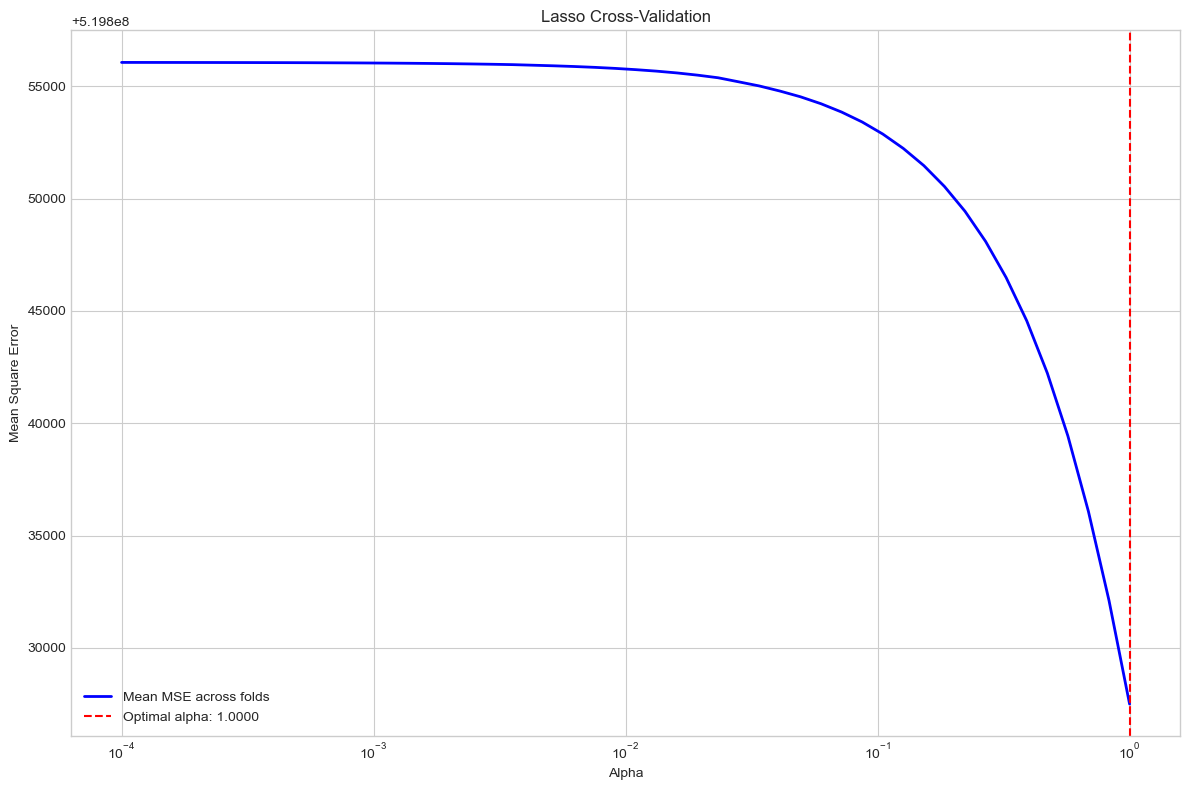

In [28]:
# 3f. Lasso regression comparison
print("\n\n3f. Lasso regression feature selection:")

# Prepare data (using standardized features from earlier)
X_lasso = data_reduced.select_dtypes(include=['number']).drop('SalePrice', axis=1, errors='ignore')
y_lasso = data_reduced['SalePrice']

# Standardize features
scaler = StandardScaler()
X_lasso_scaled = scaler.fit_transform(X_lasso)

# Find optimal alpha through cross-validation (better than fixed value)
from sklearn.linear_model import LassoCV

# Run LassoCV to find best alpha
lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5, random_state=42)
lasso_cv.fit(X_lasso_scaled, y_lasso)
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha from cross-validation: {optimal_alpha:.6f}")

# Get features dropped by Lasso at optimal alpha
lasso = Lasso(alpha=optimal_alpha)
lasso.fit(X_lasso_scaled, y_lasso)
lasso_dropped = set(X_lasso.columns[lasso.coef_ == 0])

# Get features kept by Lasso
lasso_kept = set(X_lasso.columns[lasso.coef_ != 0])

# Compare with features dropped by other methods
ols_dropped = set(X.columns) - set(significant_features.columns)
vif_dropped = set(significant_features.columns) - set(significant_features_low_vif.columns)

print("\nFeature Elimination Comparison:")
print(f"Total features: {len(X_lasso.columns)}")
print(f"Features dropped by OLS p-value: {len(ols_dropped)}")
print(f"Features dropped by VIF: {len(vif_dropped)}")
print(f"Features dropped by Lasso: {len(lasso_dropped)}")

print("\nOverlap Analysis:")
print(f"Features dropped by both OLS and Lasso: {len(ols_dropped & lasso_dropped)}")
print(f"Features dropped by both VIF and Lasso: {len(vif_dropped & lasso_dropped)}")
print(f"Features kept by all methods: {len(lasso_kept & set(significant_features_low_vif.columns))}")

# Visualize the Lasso path
plt.figure(figsize=(12, 8))
plt.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=-1), 'b-',
            label='Mean MSE across folds', linewidth=2)
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--',
           label=f'Optimal alpha: {optimal_alpha:.4f}')
plt.xlabel('Alpha')
plt.ylabel('Mean Square Error')
plt.title('Lasso Cross-Validation')
plt.legend()
plt.savefig('lasso_cv_path.png')
plt.tight_layout()
plt.show()